In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(base_dir, output_dir, test_size=0.2, val_size=0.1, random_state=42):
    """
    Splits the dataset into train, test, and validation sets, preserving images, labels, and XML files.

    Args:
        base_dir (str): Path to the base dataset directory containing 'images', 'labels', and 'xml'.
        output_dir (str): Path to save the split datasets.
        test_size (float): Proportion of data to allocate to the test set.
        val_size (float): Proportion of data to allocate to the validation set.
        random_state (int): Random seed for reproducibility.
    """
    # Paths for images, labels, and xml files
    images_dir = os.path.join(base_dir, "images")
    labels_dir = os.path.join(base_dir, "labels")
    xml_dir = os.path.join(base_dir, "xml")

    # Collect all XML files
    xml_files = [f for f in os.listdir(xml_dir) if f.endswith(".xml")]

    if not xml_files:
        raise ValueError("No XML files found in the 'xml' directory. Please check the path and files.")

    # Split into train, test, and val
    train_val_files, test_files = train_test_split(xml_files, test_size=test_size, random_state=random_state)
    train_files, val_files = train_test_split(train_val_files, test_size=val_size / (1 - test_size), random_state=random_state)

    # Helper function to copy files
    def copy_files(file_list, split_name):
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(os.path.join(split_dir, "images"), exist_ok=True)
        os.makedirs(os.path.join(split_dir, "labels"), exist_ok=True)
        os.makedirs(os.path.join(split_dir, "xml"), exist_ok=True)

        for xml_file in file_list:
            # Copy XML file
            shutil.copy(os.path.join(xml_dir, xml_file), os.path.join(split_dir, "xml", xml_file))

            # Copy corresponding image file
            image_file = xml_file.replace(".xml", ".jpg")  # Assuming images are .jpg
            if os.path.exists(os.path.join(images_dir, image_file)):
                shutil.copy(os.path.join(images_dir, image_file), os.path.join(split_dir, "images", image_file))

            # Copy corresponding label file
            label_file = xml_file.replace(".xml", ".txt")  # Assuming labels are .txt
            if os.path.exists(os.path.join(labels_dir, label_file)):
                shutil.copy(os.path.join(labels_dir, label_file), os.path.join(split_dir, "labels", label_file))

    # Copy files to respective directories
    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print(f"Data split complete: Train ({len(train_files)}), Val ({len(val_files)}), Test ({len(test_files)})")

# Example usage
base_dir = "/content/drive/MyDrive/CTOS"  # Path to your dataset containing 'images', 'labels', 'xml'
output_dir = "/content/drive/MyDrive/CTOS/output/split"  # Path to save the split dataset
split_dataset(base_dir, output_dir)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CTOS/xml'

In [ ]:
import os
dataset_dir = "/content/drive/MyDrive/CTOS/xml"
xml_files = [f for f in os.listdir(dataset_dir) if f.endswith(".xml")]
print(f"XML files found: {xml_files}")
print(f"Number of XML files: {len(xml_files)}")

XML files found: ['112.xml', '111.xml', '103.xml', '11.xml', '105.xml', '100.xml', '104.xml', '110.xml', '10.xml', '107.xml', '1.xml', '102.xml', '108.xml', '101.xml', '109.xml', '106.xml', '134.xml', '125.xml', '126.xml', '123.xml', '14.xml', '120.xml', '140.xml', '141.xml', '136.xml', '13.xml', '139.xml', '138.xml', '129.xml', '142.xml', '128.xml', '132.xml', '133.xml', '127.xml', '113.xml', '121.xml', '117.xml', '130.xml', '131.xml', '137.xml', '116.xml', '118.xml', '119.xml', '122.xml', '124.xml', '12.xml', '135.xml', '115.xml', '114.xml', '161.xml', '155.xml', '165.xml', '17.xml', '158.xml', '157.xml', '143.xml', '169.xml', '151.xml', '150.xml', '147.xml', '144.xml', '168.xml', '16.xml', '167.xml', '166.xml', '170.xml', '15.xml', '146.xml', '160.xml', '145.xml', '154.xml', '152.xml', '163.xml', '148.xml', '164.xml', '162.xml', '156.xml', '149.xml', '159.xml', '153.xml', '199.xml', '192.xml', '175.xml', '182.xml', '194.xml', '176.xml', '187.xml', '181.xml', '179.xml', '173.xml', '1

In [ ]:
print(len([f for f in os.listdir('/content/drive/MyDrive/CTOS/output/split/test/images') if f.endswith(('.jpg', '.png'))]))
print(len([f for f in os.listdir('/content/drive/MyDrive/CTOS/output/split/train/images') if f.endswith(('.jpg', '.png'))]))
print(len([f for f in os.listdir('/content/drive/MyDrive/CTOS/output/split/val/images') if f.endswith(('.jpg', '.png'))]))


86
300
43


In [ ]:
import os
import json
import xml.etree.ElementTree as ET
from tqdm import tqdm

def xml_to_coco(xml_dir, image_dir, output_json):
    """
    Converts XML annotations to COCO format.

    Args:
        xml_dir (str): Directory containing XML annotation files.
        image_dir (str): Directory containing image files.
        output_json (str): Path to save the COCO format JSON.
    """
    images = []
    annotations = []
    categories = []
    category_mapping = {}
    annotation_id = 1

    # Iterate through XML files
    for idx, xml_file in enumerate(tqdm(os.listdir(xml_dir))):
        if not xml_file.endswith(".xml"):
            continue

        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()

        # Image metadata
        filename = root.find("filename").text
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)
        image_id = idx + 1

        images.append({
            "id": image_id,
            "file_name": filename,
            "width": width,
            "height": height,
        })

        # Object annotations
        for obj in root.findall("object"):
            category_name = obj.find("name").text

            # Map category name to an ID
            if category_name not in category_mapping:
                category_mapping[category_name] = len(category_mapping) + 1
                categories.append({
                    "id": category_mapping[category_name],
                    "name": category_name,
                    "supercategory": "none",
                })

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            width_bbox = xmax - xmin
            height_bbox = ymax - ymin

            annotations.append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_mapping[category_name],
                "bbox": [xmin, ymin, width_bbox, height_bbox],
                "area": width_bbox * height_bbox,
                "iscrowd": 0,
            })
            annotation_id += 1

    # Create COCO format JSON
    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": categories,
    }

    # Save as JSON
    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=4)

    print(f"COCO format annotations saved to {output_json}")


# Convert XML to COCO for train, val, and test
base_dir = "/content/drive/MyDrive/CTOS/output/split"  # Adjust the base path accordingly

splits = ["train", "val", "test"]
for split in splits:
    xml_dir = os.path.join(base_dir, split, "xml")
    image_dir = os.path.join(base_dir, split, "images")
    output_json = os.path.join(base_dir, split, f"{split}_coco.json")
    xml_to_coco(xml_dir, image_dir, output_json)


100%|██████████| 300/300 [00:01<00:00, 200.93it/s]


COCO format annotations saved to /content/drive/MyDrive/CTOS/output/split/train/train_coco.json


100%|██████████| 43/43 [00:00<00:00, 308.41it/s]


COCO format annotations saved to /content/drive/MyDrive/CTOS/output/split/val/val_coco.json


100%|██████████| 86/86 [00:00<00:00, 302.96it/s]


COCO format annotations saved to /content/drive/MyDrive/CTOS/output/split/test/test_coco.json


In [ ]:
import os
import torchvision
from transformers import DetrImageProcessor

# Initialize the image processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Paths to the dataset splits
dataset = '/content/drive/MyDrive/CTOS/output/split'
ANNOTATION_FILE_NAME = "_coco.json"  # Updated to match your directory structure
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "val")
TEST_DIRECTORY = os.path.join(dataset, "test")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        annotation_file_name: str,
        image_processor,
    ):
        annotation_file_path = os.path.join(image_directory_path, annotation_file_name)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}

        # Process the images and annotations
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


# Load datasets for train, val, and test
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, annotation_file_name="train_coco.json", image_processor=image_processor)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, annotation_file_name="val_coco.json", image_processor=image_processor)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, annotation_file_name="test_coco.json", image_processor=image_processor)

# Print dataset sizes
print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 300
Number of validation examples: 43
Number of test examples: 86


In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.4 MB/s eta 0:00:00


Image #212


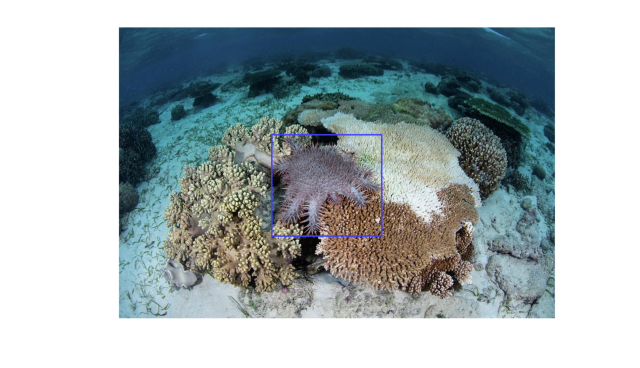

In [ ]:
import random
import os
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

# Select a random image from the training dataset
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f'Image #{image_id}')

# Load image metadata and annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root,'images' ,image_info['file_name'])

# Try loading the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Failed to load image. Check the file path: {image_path}")

# Convert BGR to RGB for proper visualization
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert COCO annotations to sv.Detections format
def coco_annotations_to_detections(coco_annotations):
    """
    Convert COCO annotations to `sv.Detections` format.
    """
    boxes = [ann['bbox'] for ann in coco_annotations]  # COCO format: [x_min, y_min, width, height]
    labels = [ann['category_id'] for ann in coco_annotations]  # Category IDs

    # Convert COCO bbox to [x_min, y_min, x_max, y_max]
    xyxy_boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]
    return sv.Detections(xyxy=np.array(xyxy_boxes), class_id=np.array(labels))

# Create detections
detections = coco_annotations_to_detections(annotations)

# Generate id2label mapping
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

# Create labels for detections
labels = [id2label[class_id] for class_id in detections.class_id]

# Annotate the image with detections
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image, detections=detections)

# Display the annotated image
plt.figure(figsize=(8, 8))
plt.imshow(annotated_frame)
plt.axis('off')
plt.show()


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [ ]:
len(id2label)

1

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.4 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay, id2label):
        """
        Initialize the DETR model with one class.

        Args:
            lr (float): Learning rate.
            lr_backbone (float): Learning rate for the backbone.
            weight_decay (float): Weight decay for the optimizer.
            id2label (dict): Mapping from label IDs to label names.
        """
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),  # Adjusting for one class
            ignore_mismatched_sizes=True
        )
        self.id2label = id2label
        self.label2id = {v: k for k, v in id2label.items()}

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        # Convert labels to the model's device
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # Log training loss and other metrics
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # Log validation loss and other metrics
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # Configure optimizer with different learning rates for backbone and other parameters
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER


In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4,id2label=id2label)

from torch.utils.data import DataLoader
import os

# Define the new path for the training dataset
NEW_TRAIN_PATH = "/content/drive/MyDrive/CTOS/output/split/train/images"
NEW_TRAIN_ANNOTATION = "/content/drive/MyDrive/CTOS/output/split/train/train_coco.json"

# Update the TRAIN_DATASET with the new path
TRAIN_DATASET = CocoDetection(
    image_directory_path=NEW_TRAIN_PATH,
    annotation_file_name=NEW_TRAIN_ANNOTATION,
    image_processor=image_processor
)

# Recreate the TRAIN_DATALOADER with the updated dataset
TRAIN_DATALOADER = DataLoader(
    dataset=TRAIN_DATASET,
    collate_fn=collate_fn,
    batch_size=4,
    shuffle=True
)

# Verify by loading a batch
batch = next(iter(TRAIN_DATALOADER))
print("Batch keys:", batch.keys())

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Batch keys: dict_keys(['pixel_values', 'pixel_mask', 'labels'])


In [ ]:
NEW_TRAIN_PATH = "/content/drive/MyDrive/CTOS/output/split/val/images"
NEW_TRAIN_ANNOTATION = "/content/drive/MyDrive/CTOS/output/split/val/val_coco.json"

# Update the TRAIN_DATASET with the new path
VAL_DATASET = CocoDetection(
    image_directory_path=NEW_TRAIN_PATH,
    annotation_file_name=NEW_TRAIN_ANNOTATION,
    image_processor=image_processor
)

# Recreate the TRAIN_DATALOADER with the updated dataset
VAL_DATALOADER = DataLoader(
    dataset=TRAIN_DATASET,
    collate_fn=collate_fn,
    batch_size=4,
    shuffle=True
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
from pytorch_lightning import Trainer

MAX_EPOCHS = 10

trainer = Trainer( max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]